In [1]:
import pandas as pd
import __main__
from model_train import Vectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tokenizer import tokenizer, word_count
import spacy
import squarify

In [2]:
df = pd.read_csv('../game_data/wrangled_reviews_vis.csv')
df_group = pd.read_csv('../game_data/wrangled_reviews.csv')

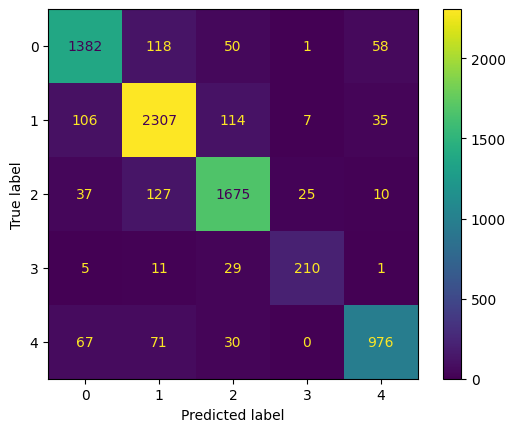

In [3]:
# Read in trained classifier model
__main__.Vectorizer = Vectorizer
model = pd.read_pickle('../ml_models/ms_score.pkl')

X = df_group.drop(columns=['Metascore', 'User Score', 'Title', 'Platform', 'Release Day of Month', 'Unnamed: 0'])

# Get predicted scores and true scores
pred = model.predict(X)
true = df_group['Metascore']

# Create a confusion matrix of models predictions
pred_df = pd.DataFrame(data={'true': true, 'pred': pred})
cm = confusion_matrix(pred_df['true'], pred_df['pred'])

# Display confusion matrix
display = ConfusionMatrixDisplay(cm)
display.plot()

In [4]:
# questions - plots:
# 1. what days/months/years of release dates have the highest scorers ==> top dates
# 2. what combination of genres is most likely to be a high scorer - heatmap ==> top genre combinations
# 3. what do the highest scorers have in common in the description written ==> top words

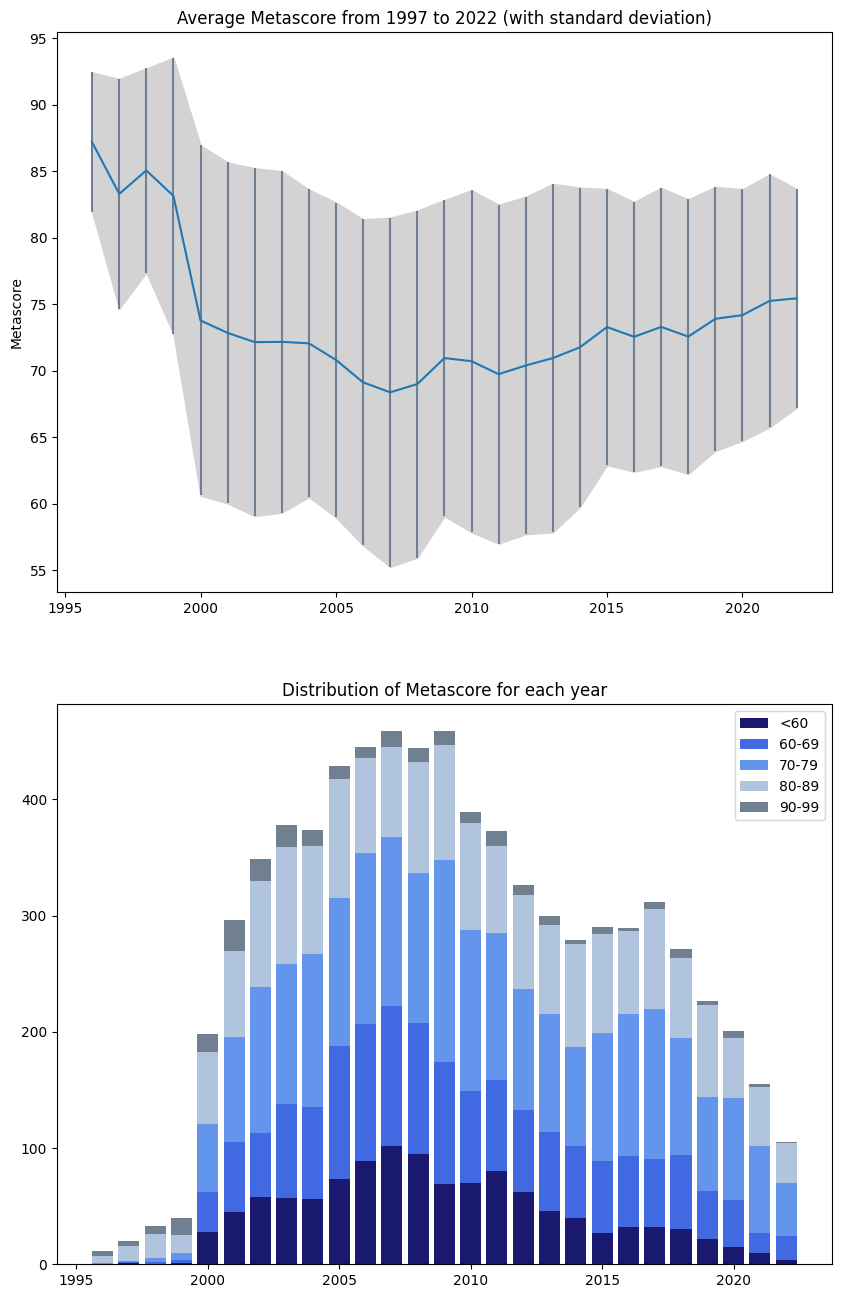

In [5]:
# question 1- years:
score = 'Metascore'

years = df['Release Year'].sort_values(ascending=True).unique()
mean = df.groupby('Release Year').mean()[score]
std = df.groupby('Release Year').std()[score]

def count(group, year):
    df_year = df_group[(df_group['Release Year'] == year) &
                       (df_group[score] == group)]
    return len(df_year)

a_counts = [count('90-99', year) for year in years]
b_counts = [count('80-89', year) for year in years]
c_counts = [count('70-79', year) for year in years]
d_counts = [count('60-69', year) for year in years]
e_counts = [count('<60', year) for year in years]

f, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 16))

def sum_counts(*counts):
    add = zip(*counts)
    sums = [sum(list(counts)) for counts in add]
    return sums

# Line plot of yearly averages with error bar using standard deviation
ax1.errorbar(x=mean.index, y=mean, yerr=std, ecolor='slategrey')
ax1.fill_between(x=mean.index, y1=(mean-std), y2=(mean+std), color='lightgrey')

# The amount of each class for each year
ax2.bar(x=years, height=e_counts, label='<60', color='midnightblue')
ax2.bar(x=years, height=d_counts, bottom=e_counts, label='60-69', color='royalblue')
ax2.bar(x=years, height=c_counts, bottom=sum_counts(d_counts, e_counts), label='70-79', color='cornflowerblue')
ax2.bar(x=years, height=b_counts, bottom=sum_counts(c_counts, d_counts, e_counts), label='80-89', color='lightsteelblue')
ax2.bar(x=years, height=a_counts, bottom=sum_counts(b_counts, c_counts, d_counts, e_counts), label='90-99', color='slategrey')

ax1.set_title(f'Average {score} from 1997 to 2022 (with standard deviation)')
ax1.set_ylabel(score)

ax2.set_title(f'Distribution of {score} for each year')
ax2.legend()

<AxesSubplot: >

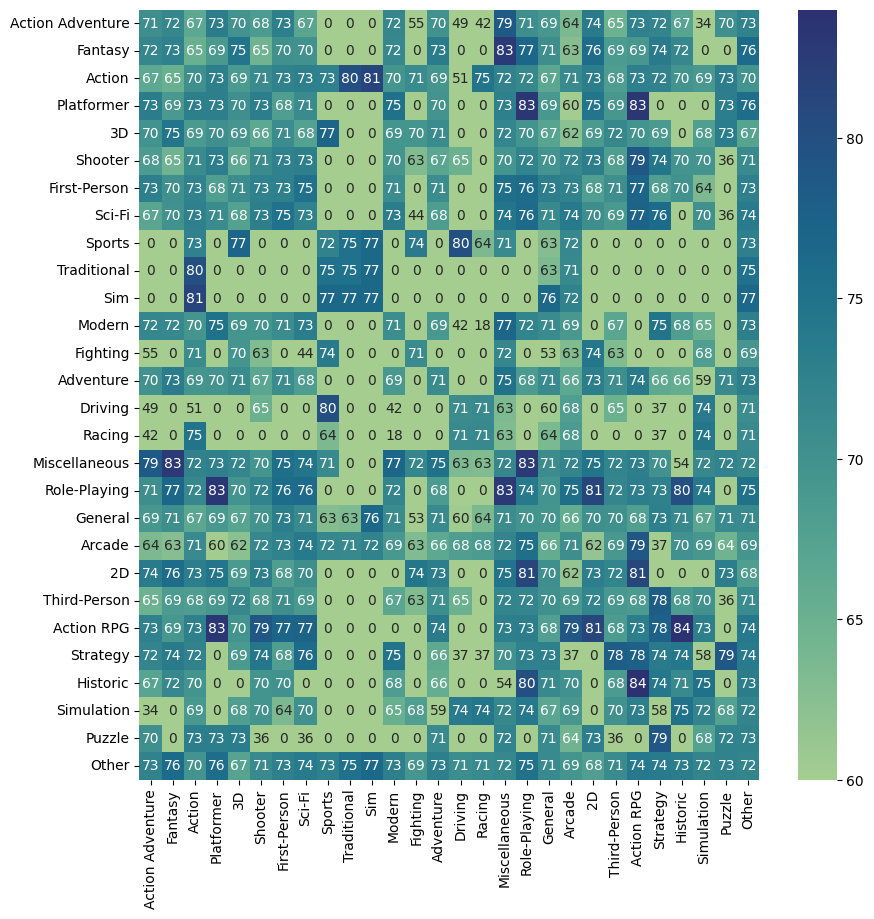

In [6]:
# question 2- genres:
score = 'Metascore'

genres = list(df.columns[13:])

data = {}

# Calculate score averages for all genre combinations of 2
for genre1 in genres:
    combo_means = []
    for genre2 in genres:
        combo_mean = df[df[genre1] == 1][df[genre2] == 1][score].mean()
        combo_means.append(combo_mean)
    data[genre1] = (combo_means)

genre_df = pd.DataFrame(data)
genre_df.fillna(0, inplace=True)
genre_df.index = genres

f, ax = plt.subplots(1,1, figsize=(10, 10))

# Heatmap displaying genre combination scores
sns.heatmap(genre_df, vmin=60, annot=True, cmap='crest', ax=ax)

<AxesSubplot: >

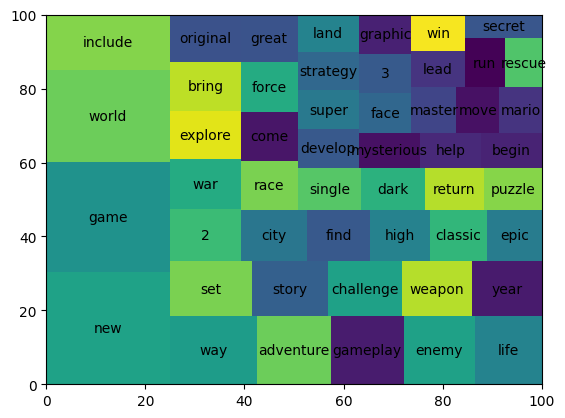

In [7]:
# question 3- descriptions
score = 'Metascore'

# Load NLP model
nlp = spacy.load('../nlp_model')

# Collect word frequencies for a score group into a dataframe
def count_df(score_group):

    # Tokenize the descriptions of all games in the score group
    tokens = df[df_group[score] == score_group]['Summary'].apply(lambda text: tokenizer(text, nlp))

    # Create a word count dataframe using the tokens
    word_df = word_count(tokens)

    # Calculate the frequency of each token based on total docs in score group
    total_docs = df_group[score].value_counts()[score_group]
    word_df['appears_in_docs'] = word_df['appears_in_docs'] / total_docs

    return word_df.sort_values(by='appears_in_docs', ascending=False)

# Gather all score group word frequencies into one dataframe
word_df = count_df('90-99')
for group in ['80-89', '70-79', '60-69', '<60']:
    word_df = word_df.merge(count_df(group), on='word', how='left',)

word_df.fillna(0, inplace=True)
word_df.columns = ['word', 'appears_in_90', 'appears_in_80', 'appears_in_70', 'appears_in_60', 'appears_in_<60']

# Filter dataframe by keeping only words that are more frequent in the top score group
top_words = word_df[(word_df['appears_in_90'] > word_df['appears_in_80']) &
                    (word_df['appears_in_90'] > word_df['appears_in_70']) &
                    (word_df['appears_in_90'] > word_df['appears_in_60']) &
                    (word_df['appears_in_90'] > word_df['appears_in_<60']) &
                    (word_df['word'] != ' ')].head(50)

# Squarify plot of the top words in the top score group
squarify.plot(top_words['appears_in_90'], label=top_words['word'])